In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import itertools
from itertools import cycle

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, cohen_kappa_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
# differentiates features and class
def find_features_labels(data):
    X = np.array(data.iloc[:, data.columns!= 'Class'])
    Y = np.array(data.iloc[:, data.columns == 'Class'])
    return X, Y

In [3]:
#normalizing data
def normalizeData(data):
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    data["normalized_Amount"] = scalar.fit_transform(data["Amount"].values.reshape(-1,1))
    data = data.drop(["Time","Amount"], axis=1)
    return data

In [24]:
# performs undersampling
def underSampling(data):

    X, Y = find_features_labels(data)

    rs  = RandomUnderSampler(sampling_strategy = 'auto', random_state=42, replacement= False)
    X_UnderSample, Y_UnderSample = rs.fit_resample(X,  Y.reshape(len(Y)))

    X = np.array(X_UnderSample)
    Y = np.array(Y_UnderSample)

    return X, Y

In [30]:
#performs smote
def Smote(data):

    X,Y = find_features_labels(data)

    sm = SMOTE(sampling_strategy='minority', random_state=42,)
    X_smote, Y_smote = sm.fit_resample(X, Y.reshape(len(Y)))

    X = np.array(X_smote)
    Y = np.array(Y_smote)

    return X, Y

In [6]:
#find the train test split
def cal_train_test_split(X,Y):

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42)
    return  X_train, X_test, Y_train, Y_test

In [7]:
#plot confusion matrix
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=pyplot.cm.Blues):

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=0)
    pyplot.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [8]:
#plot precision recall curves
def plot_precision_recall(y_proba, Y_test_under):

    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.70, 0.75, 0.8, 0.9, 0,95]
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue', 'black'])

    pyplot.figure(figsize=(5, 5))

    j = 1
    for i, color in zip(thresholds, colors):
        y_test_predictions_prob = y_proba[:, 1] > i

        precision, recall, thresholds = precision_recall_curve(Y_test_under, y_test_predictions_prob)

        # Plot Precision-Recall curve
        pyplot.plot(recall, precision, color=color,
                 label='Threshold: %s' % i)
        pyplot.xlabel('RECALL')
        pyplot.ylabel('PRECISION')
        pyplot.ylim([0.0, 1.05])
        pyplot.xlim([0.0, 1.0])
        pyplot.title('Precision-Recall Plot')
        pyplot.legend(loc="lower left")
    pyplot.show()


In [9]:
#plot auc roc curve
def plot_AUC_ROC_curve(y_pred_incomplete, Y_test_under):

    fpr, tpr, thresholds = roc_curve( Y_test_under, y_pred_incomplete)
    roc_auc = auc(fpr, tpr)

    pyplot.title('Receiver Operating Characteristic')
    pyplot.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    pyplot.legend(loc='lower right')
    pyplot.plot([0, 1], [0, 1], 'r--')
    pyplot.xlim([-0.1, 1.0])
    pyplot.ylim([-0.1, 1.01])
    pyplot.ylabel('True Positive Rate')
    pyplot.xlabel('False Positive Rate')
    pyplot.show()
    return roc_auc


In [10]:
def performance_metrics(Y_test_complete, y_pred):

    cnf_matrix = confusion_matrix(Y_test_complete, y_pred)
    recall = recall_score(Y_test_complete, y_pred, average=None)

    #confusion matrix plot calling
    class_names = [0, 1]
    pyplot.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
    return cnf_matrix, recall

In [11]:
# =----------------- 10 fold cross validation ------------------------

def unbalanced_randomForest(data):

    X, Y = find_features_labels(data)
    meanRecall, meanKappa = predict_RandomForest(X, Y)
    print("Mean Recall (imbalanced): ", meanRecall)
    print("Mean Kappa (imbalanced): ", meanKappa)
    print()

    X_train_under, X_test_under, Y_train_under, Y_test_under = cal_train_test_split(X, Y)
    Y_test_complete, y_pred, y_proba, y_pred_incomplete = RandomForest_Complete(X_train_under, X_test_under, Y_train_under, Y_test_under,
                                                   X_train_under, X_test_under, Y_train_under, Y_test_under)

    # performance metric
    cnf_matrix, recall = performance_metrics(Y_test_complete, y_pred)
    pyplot.show()
    plot_precision_recall(y_proba, Y_test_complete)
    auc = plot_AUC_ROC_curve(y_pred, Y_test_complete)

    print("Confusion Metrix Random Forest (imbalanced)) : \n", cnf_matrix)
    print("Recall  (imbalanced ) : ", recall)
    print("AUC ROC  (imbalanced ) : ", auc)

In [12]:
def undersampling_randomForest(data):

    X, Y = underSampling(data)
    meanRecall, meanKappa = predict_RandomForest(X, Y)
    print("Mean Recall (undersampling): ", meanRecall)
    print("Mean Kappa (undersampling): ", meanKappa)
    print()
     #performance on whole data

    #under-sampling split
    X_train_under, X_test_under, Y_train_under, Y_test_under = cal_train_test_split(X,Y)
    #complete data split
    X_complete, Y_complete = find_features_labels(data)
    X_train_complete, X_test_complete, Y_train_complete, Y_test_complete = cal_train_test_split(X_complete, Y_complete)

    #random forrest train test split
    Y_test_complete, y_pred, y_proba, y_pred_incomplete = RandomForest_Complete(X_train_under, X_test_under, Y_train_under, Y_test_under, X_train_complete, X_test_complete, Y_train_complete, Y_test_complete)

    #performace metric
    cnf_matrix, recall  = performance_metrics(Y_test_complete, y_pred)
    pyplot.show()

    plot_precision_recall(y_proba, Y_test_complete)

    auc = plot_AUC_ROC_curve(y_pred, Y_test_complete)


    print("Confusion Matrix Random Forest (Undersampled):\n ", cnf_matrix)
    print("Racall (Undersampled) : ", recall)
    print("AUC ROC (Undersampled) : ", auc)

In [13]:
def smote_randomForest(data):

    X, Y = Smote(data)
    meanRecall, meanKappa = predict_RandomForest(X, Y)
    print("Mean Recall (SMOTEsampling): ", meanRecall)
    print("Mean Kappa (SMOTEsampling): ", meanKappa)
    print()

    #whole data

    #split oversampling
    X_train_under, X_test_under, Y_train_under, Y_test_under = cal_train_test_split(X, Y)

    #split complete data
    X_complete, Y_complete = find_features_labels(data)
    X_train_complete, X_test_complete, Y_train_complete, Y_test_complete = cal_train_test_split(X_complete, Y_complete)


    Y_test_complete, y_pred, y_proba, y_pred_incomplete = RandomForest_Complete(X_train_under, X_test_under, Y_train_under, Y_test_under, X_train_complete,
                                          X_test_complete, Y_train_complete, Y_test_complete)

    #performance metric, confusion matrix and recall
    cnf_matrix, recall = performance_metrics(Y_test_complete, y_pred)
    pyplot.show()
    plot_precision_recall(y_proba, Y_test_complete)
    auc = plot_AUC_ROC_curve(y_pred, Y_test_complete)

    print("Confusion Metrix Random Forest (SMOTE) : \n", cnf_matrix)
    print("Recall  (SMOTE) : ", recall)
    print("AUC ROC  (SMOTE) : ", auc)

In [14]:
def predict_RandomForest(X,Y):

    recallScore = []
    kappaScore = []

    rf = RandomForestClassifier(n_jobs=3, min_samples_split = 20, min_samples_leaf = 5)

    kf = KFold(n_splits=5, random_state=None, shuffle=True)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        rf.fit(X_train, Y_train.reshape(len(Y_train)))
        predicted = rf.predict(X_test)

        recall = recall_score(Y_test, predicted, average=None)
        recallScore.append(recall)
        kappa = cohen_kappa_score(Y_test, predicted)
        kappaScore.append(kappa)

    meanRecall = sum(recallScore) / len(recallScore)
    meanKappa = sum(kappaScore) / len(kappaScore)

    return meanRecall, meanKappa

In [15]:
# ----------- train test splitting ---------------------
def RandomForest_Complete(X_train_under, X_test_under, Y_train_under, Y_test_under, X_train_complete,
                   X_test_complete, Y_train_complete, Y_test_complete):

    rf = RandomForestClassifier(n_jobs=3, min_samples_split = 20, min_samples_leaf = 5)

    rf.fit(X_train_under, Y_train_under.ravel())

    y_pred = rf.predict(X_test_complete)

    y_proba = rf.predict_proba(X_test_complete)

    y_pred_incomplete = rf.predict(X_test_under)

    return Y_test_complete, y_pred, y_proba, y_pred_incomplete

---------------- 5 fold cross validation -------------------------------- 

Mean Recall (imbalanced):  [0.99988745 0.77116629]
Mean Kappa (imbalanced):  0.8401032835119409



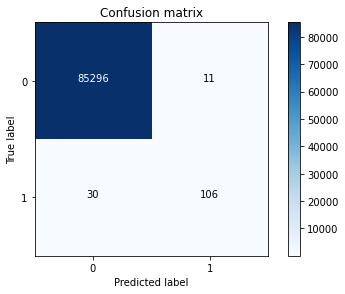

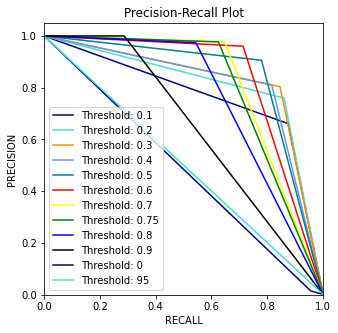

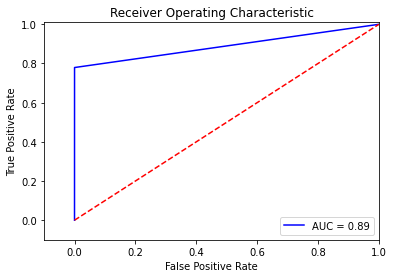

Confusion Metrix Random Forest (imbalanced)) : 
 [[85296    11]
 [   30   106]]
Recall  (imbalanced ) :  [0.99987105 0.77941176]
AUC ROC  (imbalanced ) :  0.8896414093319699


In [16]:
data = pd.read_csv("dataset/creditcard.csv")
print("---------------- 5 fold cross validation -------------------------------- ")
print()
unbalanced_randomForest(data)

In [17]:

print("----------------                          -------------------------------- ")
print()

----------------                          -------------------------------- 



Mean Recall (undersampling):  [0.97990481 0.89278435]
Mean Kappa (undersampling):  0.871199393467289



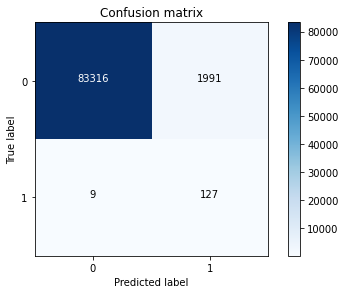

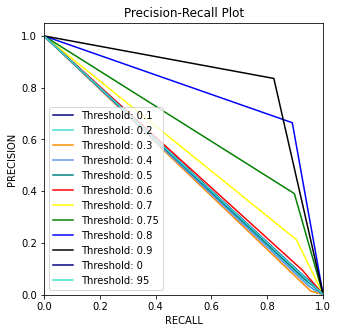

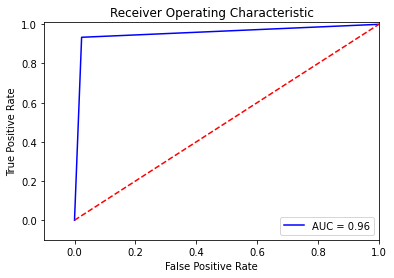

Confusion Matrix Random Forest (Undersampled):
  [[83316  1991]
 [    9   127]]
Racall (Undersampled) :  [0.97666077 0.93382353]
AUC ROC (Undersampled) :  0.9552421479100743
----------------                          -------------------------------- 



In [25]:
undersampling_randomForest(data)
print("----------------                          -------------------------------- ")
print()

In [29]:
smote_randomForest(data)
print()

AttributeError: 'SMOTE' object has no attribute 'fit_sample'